# Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras import Sequential
from keras import losses, metrics, optimizers
from keras.applications import mobilenet
from keras.layers import Input, Dense, Conv2D, Flatten, LeakyReLU, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Reshape
import numpy as np
import matplotlib.pyplot as plt
import os

Num GPUs Available:  1


Funcion para extraer los datos de los ficheros

In [2]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Extraemos los datos del fichero.

In [3]:
batch1 = unpickle("Input\cifar-10-batches-py\data_batch_1")
batch2 = unpickle("Input\cifar-10-batches-py\data_batch_2")
batch3 = unpickle("Input\cifar-10-batches-py\data_batch_3")
batch4 = unpickle("Input\cifar-10-batches-py\data_batch_4")
batch5 = unpickle("Input\cifar-10-batches-py\data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [4]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [5]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


(-0.5, 31.5, 31.5, -0.5)

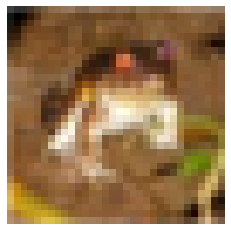

In [6]:
plt.imshow(imagen)
plt.axis("off")

# Preparacion de los datos

Cargamos todas las imagenes de entrenamiento en la variable ``X_train`` y borramos todo lo demás ya que no lo vamos a utilizar.

In [7]:
print(batch1["data"].shape)
X_train = batch1["data"].reshape(10000, 3, 32, 32)
del batch1
X_train = np.concatenate((X_train, batch2["data"].reshape(10000, 3, 32, 32)))
del batch2
X_train = np.concatenate((X_train, batch3["data"].reshape(10000, 3, 32, 32)))
del batch3
X_train = np.concatenate((X_train, batch4["data"].reshape(10000, 3, 32, 32)))
del batch4
X_train = np.concatenate((X_train, batch5["data"].reshape(10000, 3, 32, 32)))
del batch5
X_train = X_train.transpose(0,2,3,1)
X_train=X_train/255

(10000, 3072)


(50000, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

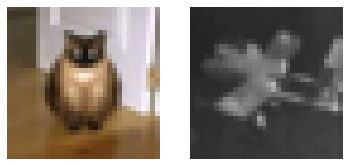

In [8]:
print(X_train.shape)
plt.figure()
f, arrx = plt.subplots(1,2)
arrx[0].imshow(X_train[np.random.randint(0,X_train.shape[0])])
arrx[1].imshow(X_train[np.random.randint(0,X_train.shape[0])])
for a in arrx:
    a.axis("off")

# Arquitectura del ``Autoencoder``

## Regla de la piramide geometrica

La regla de la piramide geometrica sirve para ayudar determinar el tamaño de las capas ocultas en base al tamaño de las capas de input y output y al numero de capas ocultas. 

Esta aproximacion esta propuesta por Masters(1993): 
>  "For a three layer network with n input and m output neurons, the hidden layer would have sqrt(N * M) neurons."
>
> -- <cite> Masters, Timothy. Pratical neural network recipes in C++. Morgan Kaufmann, 1993.</cite>

[Enlace al artículo](https://eulertech.wordpress.com/2018/01/02/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-network/)

In [9]:
def pyramid_rule(h_layers, input_size, output_size):
    layers = []
    if h_layers < 1:
        print("No layers")
        return []
    print("Layers for input %d and output %d:" % (input_size,  output_size))
    rate = (input_size/output_size)**(1/(h_layers+1))
    for l in range(h_layers):
        layer_size = output_size*(rate**(h_layers-l))
        layer_size = round(layer_size)
        layers.append(layer_size)
        print("Layer %d: %d neurons" % (l+1, layer_size))
    return layers

## EMD(Earth Mover's Distance) ``WIP``

EMD es una medida de distancia entre distribuciones de probabilidad, que consiste en representar ambas distribuciones como montones de tierra, en los que la distancia se determina en cuanto es el trabajo minimo que llevaria transformar un monticulo en otro. Matematicamente a EMD se la conoce como la métrica de Wasserstein.

$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(p_i-q_i)^2}$

Siendo p y q la prediccion y el verdadero.

In [10]:
def EMD_loss(y_true, y_pred):
	n = np.prod(y_true.shape)
	p = tf.math.subtract(y_true, y_pred)
	p = tf.math.square(p)
	p = tf.math.reduce_sum(p)
	return tf.math.sqrt(tf.math.divide(p,n))

## Encoders

### Transfer Encoder

Éste ``encoder`` va a ser un modelo basado en ``transfer learning``, vamos a tomar la red de ``mobilenet``, entranada para imagenes de ``imagenet`` sin las capa de clasificacion final, con una entrada de tamaño _img\_shape_ y en el output colocamos la 'representacion latente' una codificacion de la imagen que nos permitiría reconstruirla con un ``decoder``.

In [11]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
# https://keras.io/guides/transfer_learning/
def build_transf_encoder(dim_latente, img_shape, trainable=False):
    inputs = Input(shape=img_shape)
    x=tf.cast(inputs, tf.float32)
    #x=keras.applications.mobilenet.preprocess_input(x)  #dataformat por defecto es chanel last
    core = mobilenet.MobileNet(input_shape=(img_shape), weights="imagenet", include_top=False)
    core.trainable = trainable
    model = core(x, training=trainable)
    model = GlobalAveragePooling2D()(model)
    repr_latente = Dense(dim_latente)(model)
    return keras.Model(inputs, repr_latente)


In [12]:

enc = build_transf_encoder(20, (32,32,3))
enc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                                 
Total params: 3,249,364
Trainable params: 20,500
Non-trainabl

### Encoder denso

In [13]:
def build_dense_encoder(dim_latente, img_shape, depth=2):
    layer_sizes = pyramid_rule(depth, np.prod(img_shape), dim_latente)
    model =  keras.Sequential()
    model.add(Flatten(input_shape=img_shape))
    for ls in layer_sizes:
        model.add(Dense(ls))
        model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(dim_latente))
    return model

In [14]:
enc = build_dense_encoder(20, (32,32,3))
enc.summary()

Layers for input 3072 and output 20:
Layer 1: 574 neurons
Layer 2: 107 neurons
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 574)               1763902   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 574)               0         
                                                                 
 dense_2 (Dense)             (None, 107)               61525     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 107)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                2160      
                                           

### Encoder convolucional

In [15]:
def build_conv_encoder(dim_latente, img_shape, depth=2):
    model =  keras.Sequential()
    model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=img_shape))
    model.add(MaxPooling2D())
    for _ in range(depth-1):
        model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
        model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(dim_latente))
    
    return model

In [16]:
enc = build_conv_encoder(20, (32,32,3))
enc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 20)               

## Decoders

### Decoder denso

In [17]:
def build_dense_decoder(dim_latente, img_shape, depth=2):
    model = keras.Sequential()
    layer_sizes = pyramid_rule(depth, dim_latente, np.prod(img_shape))
    model.add(Dense(layer_sizes[0], input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    for i in range(1, depth):
        model.add(Dense(layer_sizes[i], input_dim=dim_latente))
        model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation=keras.activations.sigmoid))
    model.add(Reshape(img_shape))
    
    return model

In [18]:
enc = build_dense_decoder(20, (32,32,3))
enc.summary()

Layers for input 20 and output 3072:
Layer 1: 107 neurons
Layer 2: 574 neurons
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 107)               2247      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 107)               0         
                                                                 
 dense_6 (Dense)             (None, 574)               61992     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 574)               0         
                                                                 
 dense_7 (Dense)             (None, 3072)              1766400   
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                         

### Decoder convolucional

In [19]:
def build_conv_decoder(dim_latente, img_shape, depth=2):
    model=keras.Sequential()
    model.add(Dense(dim_latente, input_dim=(dim_latente)))
    model.add(Dense(2048))              #hard coded
    model.add(Reshape((8, 8, 32)))      #hard coded
    for _ in range(depth):
        model.add(Conv2D(32, (3,3), padding="same"))
        model.add(UpSampling2D())
    model.add(Conv2D(3, (3, 3), padding="same", activation=keras.activations.sigmoid))
    
    return model

In [20]:
dec = build_conv_decoder(20, (32,32,3))
dec.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 2048)              43008     
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                      

In [21]:
#optimizer = keras.optimizers.Adam(0.0002, 0.5)
#dim_latente=64
#img_shape=X_train[0].shape

#encoder = build_conv_encoder(dim_latente, img_shape)
#decoder = build_conv_decoder(dim_latente, img_shape)
#img = keras.layers.Input(img_shape)

#encoder_rep = encoder(img)
#autoencoder_out = decoder(encoder_rep)

#autoencoder = keras.Model(img, autoencoder_out)
#autoencoder.compile(loss='mse', optimizer=optimizer, metrics=["accuracy"])
#out = autoencoder.predict(X_train[0])

## Discriminador

El discriminador va a tener como entrada la codificacion latente de las imagenes y como salida una neurona que discrimina entre imagenes "reales" y "falsas". De esta forma entrenamos al encoder para que codifique con la distribucion que usemos para generar las "imagenes reales", en este caso, una distribución normal.

In [22]:
def build_discriminator(dim_latente, depth = 2):
    layer_sizes = pyramid_rule(depth, dim_latente, 1)
    model = Sequential()
    model.add(Dense(layer_sizes[0], input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    for i in range(1, depth):
        model.add(Dense(layer_sizes[i]))
        model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation=keras.activations.sigmoid))
    encoded = Input(shape=dim_latente)
    valid = model(encoded)
    return keras.Model(encoded, valid)

# Redes

Parametros

In [23]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)

Metodo para la construccion

In [24]:
def assemble_AAE(dim_latente, img_shape, enc_model=build_dense_encoder, dec_model=build_dense_decoder, disc_model = build_discriminator, 
                 ae_loss = losses.mean_squared_error, disc_loss= losses.binary_crossentropy):
    # Discriminador
    discriminator = disc_model(dim_latente)
    discriminator.compile(loss=disc_loss, metrics="accuracy")

    # Encoder y decoder
    encoder = enc_model(dim_latente, img_shape)
    decoder = dec_model(dim_latente, img_shape)

    # Autoencoder
    # el encoder toma un imagen y la codifica y el decoder toma la codificacion e intenta regenerar la imagen
    img = Input(shape=img_shape)
    encoded = encoder(img)
    reconstructed = decoder(encoded)

    # para el autoencoder adversario solo queremos entrenar el generador, no el discriminador
    discriminator.trainable=False

    # El discriminador evalua la validez de la codificacion
    validez = discriminator(encoded)

    # Autoencoder adversario 
    a_autoencoder = keras.Model(img, [reconstructed, validez])
    a_autoencoder.compile(loss=[ae_loss, disc_loss], loss_weights=[0.999, 0.001], optimizer=optimizer)
    return (encoder, decoder, discriminator, a_autoencoder)

# Entrenamiento

## Persistencia

In [25]:
_raiz = "pruebasAAE"
_nombre = "pAAE"

Creamos las carpetas para almacenar el output

In [26]:
def mkfolders(ruta, output=False):
    try:
        os.makedirs(ruta)
    except OSError:
        print("Carpeta %s ya existe" % (ruta))
    if output:
        try:
            os.mkdir(ruta+"/output")
        except OSError:
            print("Carpeta %s ya existe" % (ruta+"/output"))

In [27]:
mkfolders(_raiz, True)

Carpeta pruebasAAE ya existe
Carpeta pruebasAAE/output ya existe


## Funciones de muestreo

In [28]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True, show=False, ruta=_raiz, nombre="", title="", output=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    if title!="":
        f.suptitle(title+"_"+nombre, fontsize=12)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    for i in axxs:
        for j in i:
            j.axis("off")
    if save_imgs:
        if output:
            ruta+="/output"
        savefile= ruta+"/"+nombre+"generationCIFAR10_e%d.jpg" % (epoch)
        f.savefig(savefile)
    if show:
        plt.show()
    plt.close()
    

In [29]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [30]:
def generate_samples(dim_latente, decoder, epoch, ruta=_raiz, nombre=_nombre, output=True, show=False):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)#*0.5 +0.5
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    if output:
        ruta+="\output"
    fig.savefig(ruta+"\\"+nombre+"progresscifar10_e%d.png" % (epoch))
    if show:
        print("Imagenes generadas desde el espacio latente:")
        plt.show()
    plt.close()

    

In [31]:
from IPython.display import Image
from IPython.display import display
def show_prevResults(ruta, nombre=_nombre, epochs=5000):
    epochs = epochs - 1
    x = Image(filename=ruta+'\\output'+"\\"+nombre+"progresscifar10_e%d.png" % (epochs))
    print("Imagenes generadas desde el espacio latente:")
    display(x)

    x = Image(filename=ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    print("Historia del entrenamiento:")
    display(x)

    x = Image(filename=ruta+"/TRAINSETgenerationCIFAR10_e%d.jpg" % (epochs))
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):") 
    display(x) 
     
    x = Image(filename=ruta+"/TESTSETgenerationCIFAR10_e%d.jpg" % (epochs))         
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    display(x)
    

Imagenes para testing

In [32]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
sample_from = sample_from["data"]
sample_from = sample_from.reshape(10000,3,32,32)
sample_from = sample_from.transpose(0,2,3,1)
sample_from = sample_from/255

## Grafica de progreso

In [33]:
def plot_history(history, ruta=_raiz, nombre=_nombre, title=""):
    disc_loss = history[0]
    disc_acc  = history[1]
    aac_loss1 = history[2]
    aac_loss2 = history[3]

    fig, axxs = plt.subplots(1,3)
    if title != "":
        fig.suptitle(title, fontsize=16)

    fig.set_figwidth(24)
    fig.set_figheight(6)

    axxs[0].set_title("Discriminator")
    axxs[1].set_title("Discriminator")
    axxs[2].set_title("AdversarialAutoencoder")

    axxs[0].set_xlabel("Epoch")
    axxs[1].set_xlabel("Epoch")
    axxs[2].set_xlabel("Epoch")

    axxs[0].plot(disc_loss, label = "Loss")
    axxs[1].plot(disc_acc, label = "Accuracy")

    axxs[2].plot(aac_loss1, label = "Loss_decoder")
    axxs[2].plot(aac_loss2, label = "Loss_discriminator")

    axxs[0].legend()
    axxs[1].legend()
    axxs[2].legend()

    fig.savefig(ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    plt.show()
    plt.close()

## Funcion de entrenamiento

In [34]:
def fit_AAE(dim_latente, aae, epochs=12, batch_size=100, sample_interval=100, ruta=_raiz, nombre=_nombre, verbose=True):
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(50000, seed=2022)
    dataset = dataset.batch(batch_size)

    history = np.empty([0,4])

    encoder, decoder, discriminator, a_autoencoder=aae
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        print("EPOCH %d" % (epoch))
        for step, imgs in enumerate(dataset):
            #Espacios latentes "reales" y "falsos" para el discriminador
            latent_fake = encoder.predict(imgs)
            latent_true = true_sampler(dim_latente, batch_size)

            #entrenamos el discriminador
            dis_loss_real = discriminator.train_on_batch(latent_true, valid)
            dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

            # entrenamos al autoencoder
            aae_loss = a_autoencoder.train_on_batch(imgs,[imgs, valid])
            
            # Guardamos el progreso
            history = np.append(history, [np.append(dis_avg_loss[:2], aae_loss[:2])], axis=0)
            
            # monitorizamos el progreso
            if (step+1) % 10==0 and verbose:
                print("Epoch: %d Step: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, step, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
            # Hacemos una muestra visual
        generate_samples(dim_latente, decoder, epoch, ruta=ruta, nombre=nombre, show=((epoch+1)==epochs))
    return history.transpose(1,0)

## Entrenamiento en grid

Tamaño de la capa latente:

In [35]:
dim_latente_cand = [64, 128, 256, 512, 1024]

Tamaño de las imagenes:

In [36]:
img_shape = X_train[0].shape

Parametros:

In [37]:
encoders = [(build_dense_encoder, "dense_enc"), (build_transf_encoder,"transf_enc"), (build_conv_encoder,"conv_enc")]
decoders = [(build_dense_decoder,"dense_dec"), (build_conv_decoder,"conv_dec")]
discriminators = [(build_discriminator ,"default_disc")]
ae_losses = [(losses.mean_squared_error, "ae_MSE_loss"), (EMD_loss, "ae_EMD_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [38]:
dim_latente_cand = [64]                         # para que las pruebas no tarden 2 horas
encoders = [(build_dense_encoder, "dense_enc")] # para que las pruebas no tarden 2 horas
decoders = [(build_dense_decoder,"dense_dec")]  # para que las pruebas no tarden 2 horas

for z in dim_latente_cand:
    ruta = _raiz+"\z"+str(z)
    mkfolders(ruta, True)
    aae = assemble_AAE(z,img_shape)
    history = fit_AAE(z, aae, ruta=ruta, epochs=100)
    plot_history(history, ruta=ruta)
    

Carpeta pruebasAAE\dense_enc\dense_dec\ae_MSE_loss\default_disc\disc_binXentropy_loss\64 ya existe
Carpeta pruebasAAE\dense_enc\dense_dec\ae_MSE_loss\default_disc\disc_binXentropy_loss\64/output ya existe
Layers for input 64 and output 1:
Layer 1: 16 neurons
Layer 2: 4 neurons
Layers for input 3072 and output 64:
Layer 1: 845 neurons
Layer 2: 233 neurons
Layers for input 64 and output 3072:
Layer 1: 233 neurons
Layer 2: 845 neurons
EPOCH 0
Epoch: 0 Step: 9 Disc: (loss = 1.346749, acc = 21.00%) AAE: (mse = 0.065821, b_ce = 0.065696)
Epoch: 0 Step: 19 Disc: (loss = 1.534074, acc = 28.00%) AAE: (mse = 0.053813, b_ce = 0.053735)
Epoch: 0 Step: 29 Disc: (loss = 1.069319, acc = 24.00%) AAE: (mse = 0.053994, b_ce = 0.053689)
Epoch: 0 Step: 39 Disc: (loss = 1.035954, acc = 24.00%) AAE: (mse = 0.050837, b_ce = 0.050520)
Epoch: 0 Step: 49 Disc: (loss = 0.833682, acc = 24.50%) AAE: (mse = 0.043142, b_ce = 0.042629)
Epoch: 0 Step: 59 Disc: (loss = 0.696233, acc = 46.00%) AAE: (mse = 0.039657, b_ce

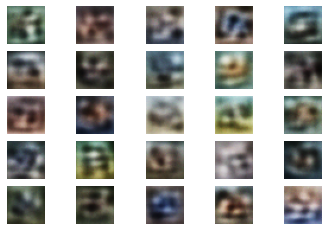

Historia del entrenamiento:


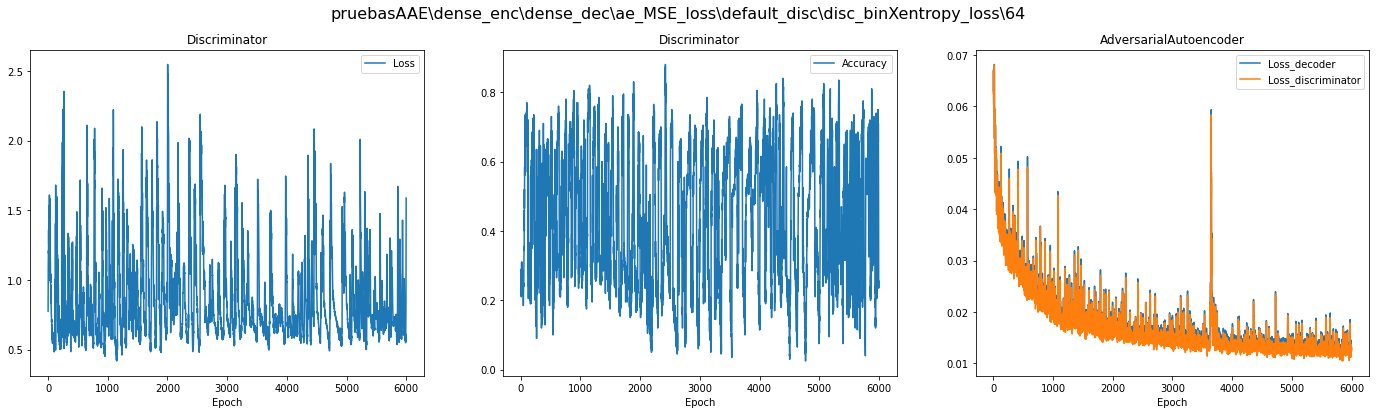

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


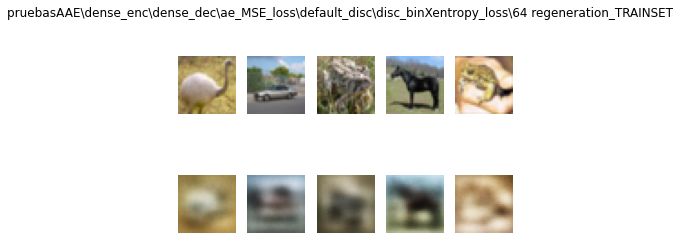

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


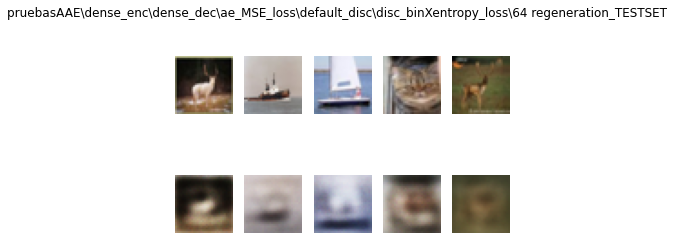

Layers for input 64 and output 1:
Layer 1: 16 neurons
Layer 2: 4 neurons
Layers for input 3072 and output 64:
Layer 1: 845 neurons
Layer 2: 233 neurons
Layers for input 64 and output 3072:
Layer 1: 233 neurons
Layer 2: 845 neurons
EPOCH 0
Epoch: 0 Step: 9 Disc: (loss = 1.364545, acc = 24.50%) AAE: (mse = 0.265408, b_ce = 0.265471)
Epoch: 0 Step: 19 Disc: (loss = 0.794113, acc = 33.50%) AAE: (mse = 0.244860, b_ce = 0.244501)
Epoch: 0 Step: 29 Disc: (loss = 0.906630, acc = 34.00%) AAE: (mse = 0.234521, b_ce = 0.234231)
Epoch: 0 Step: 39 Disc: (loss = 0.716355, acc = 58.00%) AAE: (mse = 0.235275, b_ce = 0.234638)
Epoch: 0 Step: 49 Disc: (loss = 0.568734, acc = 74.50%) AAE: (mse = 0.223858, b_ce = 0.222982)
Epoch: 0 Step: 59 Disc: (loss = 0.509333, acc = 81.00%) AAE: (mse = 0.217513, b_ce = 0.216406)
Epoch: 0 Step: 69 Disc: (loss = 0.570111, acc = 75.00%) AAE: (mse = 0.211544, b_ce = 0.210591)
Epoch: 0 Step: 79 Disc: (loss = 0.475698, acc = 79.50%) AAE: (mse = 0.197408, b_ce = 0.196081)
Ep

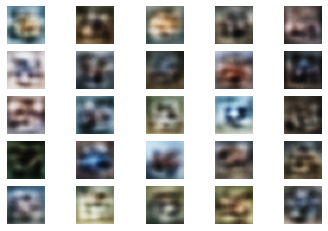

Historia del entrenamiento:


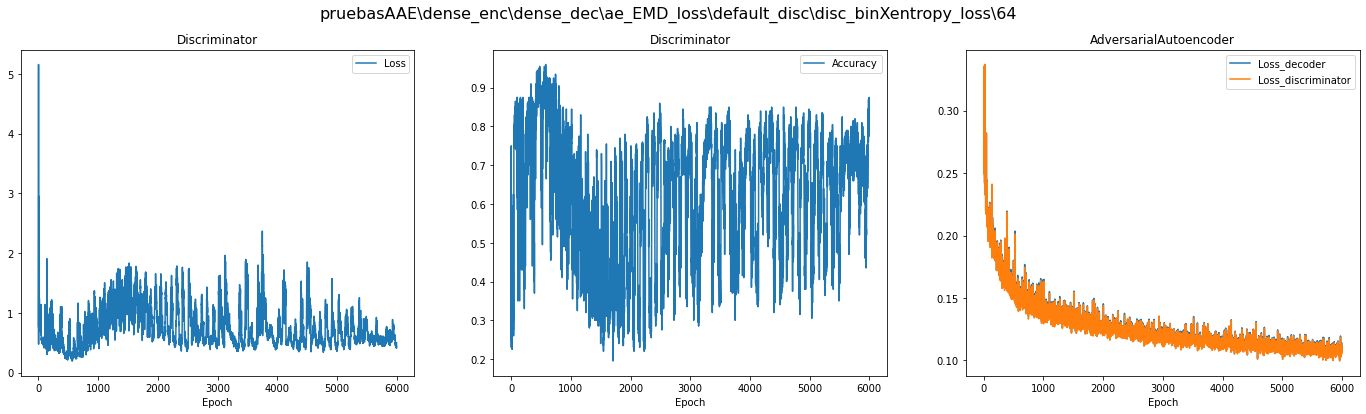

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


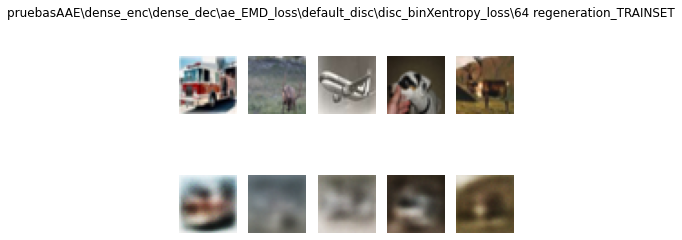

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


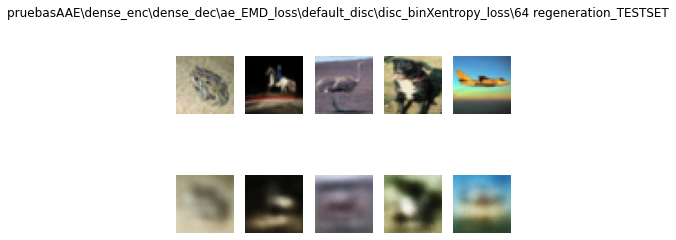

In [39]:
epochs = 12

for enc in encoders:
    for dec in decoders:
        for ae_loss in ae_losses:
            for disc in discriminators:
                for disc_loss in disc_losses:
                    for dim_latente in dim_latente_cand:
                        ruta = _raiz+"\\"+enc[1]+"\\"+dec[1]+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                        if os.path.isfile(ruta+"\\decoder.h5"):
                            print(ruta+" ya ha sido entrenada")
                            show_prevResults(ruta, epochs=epochs)
                            continue
                        mkfolders(ruta, True)
                        aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                                           ae_loss = ae_loss[0], disc_loss=disc_loss[0])
                        history = fit_AAE(dim_latente, aae, epochs=epochs, ruta = ruta)
                        print("Historia del entrenamiento:")
                        plot_history(history, ruta=ruta, title=ruta)
                        (_, decoder, _, autoencoder) = aae
                        print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                        sample_imgs(X_train, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET",output=False)
                        print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                        sample_imgs(sample_from, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET",output=False)
                        decoder.save(ruta+"\\decoder.h5")
                        autoencoder.save(ruta+"\\autoencoder.h5")